# Import Modules

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
###Modules Utilized 
import sklearn
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from nltk.corpus import stopwords
from pycaret.classification import *
from pycaret.datasets import get_data
from sklearn.preprocessing import scale
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

stopwords = stopwords.words('english')

# Set-Up Experiment

In [6]:
df_tf_m = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/cleaned_trained_data/df_tf_m')

In [7]:
df_tf_m.Flag_1.count()

312768

In [8]:
df_tf_m.Flag_1.value_counts()

2.0    282646
0.0     30122
Name: Flag_1, dtype: int64

In [9]:
#build models using data
%time s = setup(df_tf_m, target = 'Flag_1', feature_selection = True, fix_imbalance=True,train_size = 0.80,session_id = 5)

,Description,Value
0,Session id,5
1,Target,Flag_1
2,Target type,Binary
3,Target mapping,"0.0: 0, 2.0: 1"
4,Original data shape,"(312768, 800)"
5,Transformed data shape,"(514786, 160)"
6,Transformed train set shape,"(452232, 160)"
7,Transformed test set shape,"(62554, 160)"
8,Numeric features,799
9,Preprocess,True


CPU times: user 4min 28s, sys: 23 s, total: 4min 51s
Wall time: 1min 20s


# Load Previous Models

In [10]:
%time model1 = load_model('/content/drive/MyDrive/Colab Notebooks/data/models/bestmodel1')

Transformation Pipeline and Model Successfully Loaded
CPU times: user 2.01 s, sys: 1.61 s, total: 3.63 s
Wall time: 21.6 s


In [11]:
def feature_importance_df(model):
    
    df = pd.DataFrame({'Feature': get_config('X_train_transformed').columns,
                       'Value' : model.feature_importances_}).sort_values(by='Value', ascending=False)
    return df

%time features_df = feature_importance_df(model1)

features_df

CPU times: user 1.62 s, sys: 975 ms, total: 2.6 s
Wall time: 2.09 s


,Feature,Value
16,make,0.054555
115,ability,0.033867
20,told,0.026014
133,wasnt,0.025132
66,country,0.022354
...,...,...
35,little,0.001078
65,yes,0.001009
29,there,0.000790
3,incredibly,0.000705


### Get Feature Importance

In [12]:
def class_feature_importance(model,features_df):
    
    X = get_config('X_test')
    X.drop(columns=X.columns.difference(list(features_df['Feature'])), inplace=True)
    X = scale(X)
    
    Y = get_config('y_test_transformed')
    feature_importances = model.feature_importances_ 
    N, M = X.shape
    
    res = {}
    for c in set(Y):
        res[c] = dict(
            zip(range(N), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )
    return res

In [13]:
def format_features(words, result,n_features=50,remove_stopwords = True, additional_words = None):
    
    positive = result.get(0)
    negative = result.get(1) 
    
    neg = dict(zip(words,list(negative.values())))
    pos = dict(zip(words,list(positive.values())))
    
    neg = sorted(neg.items(), key=lambda item: item[1], reverse=True)
    neg = [(k,-v) for k,v in neg]
    
    pos = sorted(pos.items(), key=lambda item: item[1], reverse=True)
    
    if remove_stopwords == True and additional_words == None: 
        neg = [(w,v) for w,v in neg if w not in stopwords]
        pos = [(w,v) for w,v in pos if w not in stopwords]
        
    elif remove_stopwords == True and additional_words != None:
        new_stopwords = stopwords + additional_words
        neg = [(w,v) for w,v in neg if w not in new_stopwords]
        pos = [(w,v) for w,v in pos if w not in new_stopwords]
        
    else:
        pass
    
    return pos[:n_features] , neg[:n_features]

In [14]:
def plot_important_words(positive_sentiment, negative_sentiment, name):
    
    bottom_words = [neg[x][0] for x in range(len(negative_sentiment))]
    bottom_scores = [neg[x][1] for x in range(len(negative_sentiment))]  
    top_words = [pos[x][0] for x in range(len(positive_sentiment))]
    top_scores = [pos[x][1] for x in range(len(positive_sentiment))]  
    
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(8, 15))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative Reviews', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive Reviews', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=24)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)

    return plt

In [15]:
%time words = list(features_df['Feature'])
%time result = class_feature_importance(model1,features_df)

CPU times: user 137 µs, sys: 16 µs, total: 153 µs
Wall time: 163 µs
CPU times: user 1.44 s, sys: 762 ms, total: 2.2 s
Wall time: 1.7 s


In [16]:
remove = ['kindle','cant','john','amir','sarah','simon',
          'ive','isnt','really','see','could','lot',
          'still','but','thats','no','will','not',
          'make','seems','if','id','dont','take',
          'it','doesn','ya','pick','came','yes',
          'im','im not','you','le','ve','etc',
          'made','isnt','im','yes','no','not']

In [17]:
%time pos, neg = format_features(words, result,n_features=50, remove_stopwords = True, additional_words = remove)

CPU times: user 1.02 ms, sys: 3 µs, total: 1.02 ms
Wall time: 1.03 ms


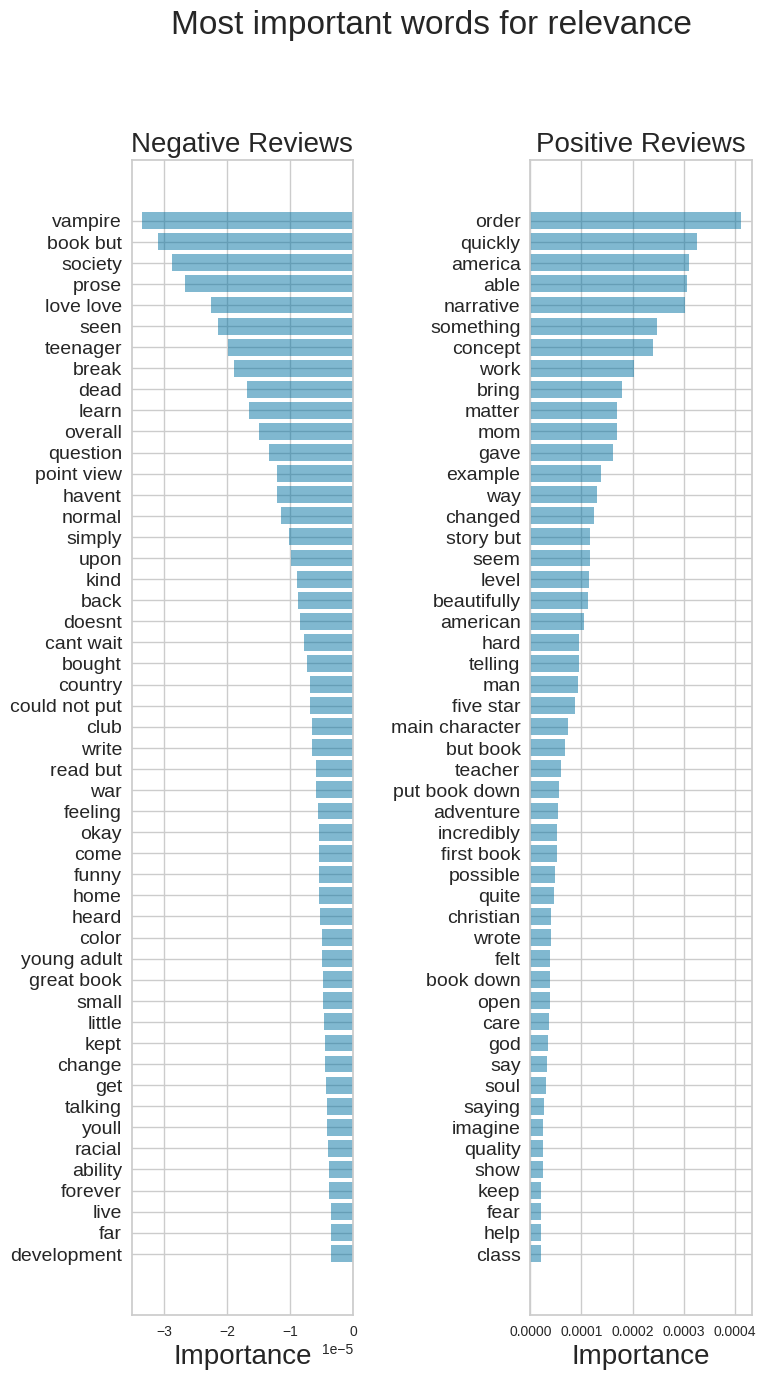

In [18]:
plot = plot_important_words(pos, neg, "Most important words for relevance")

In [29]:
df_tf_m

,Flag_1,page,race,class,ive,never,fan,girl,book,series,...,humor,sarah,cute,alice,simon,maas,vampire,green,amir,feyre
0,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.038808,0.0,0.0,0.000000,0.0,0.0,0.000000
1,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.045650,0.0,0.0,0.000000,0.0,0.0,0.000000
2,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
3,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.237546,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,2.0,0.0,0.087551,0.000000,0.0,0.0,0.0,0.090283,0.085395,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.196631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337143,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
337144,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
337145,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.324747,0.0,0.0,0.000000
337146,2.0,0.0,0.000000,0.417193,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


<Figure size 800x550 with 0 Axes>

In [20]:
model_comp = load_model('/content/drive/MyDrive/Colab Notebooks/data/models/stacker_et')
model_comp

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['page', 'race', 'class', 'ive',
                                             'never', 'fan', 'girl', 'book',
                                             'series', 'enjoyed', 'get', 'isnt',
                                             'favorite', 'however',
                                             'incredibly', 'awesom...
                                                                subsample_for_bin=200000,
                                                                subsample_freq=0))],
                                    final_estimator=LogisticRegression(C=1.0,
                                                                       class_weight=None,
                                                                       dual=False,
                                                                       fit_intercept=True,
                                                                       intercept_scaling=1,
                                                                       l1_ratio=None,
                                                                       max_iter=1000,
                                                                       multi_class='auto',
                                                                       n_jobs=None,
                                                                       penalty='l2',
                                                                       random_state=5,
                                                                       solver='lbfgs',
                                                                       tol=0.0001,
                                                                       verbose=0,
                                                                       warm_start=False),
                                    n_jobs=-1, passthrough=True,
                                    stack_method='auto', verbose=0))],
         verbose=False)

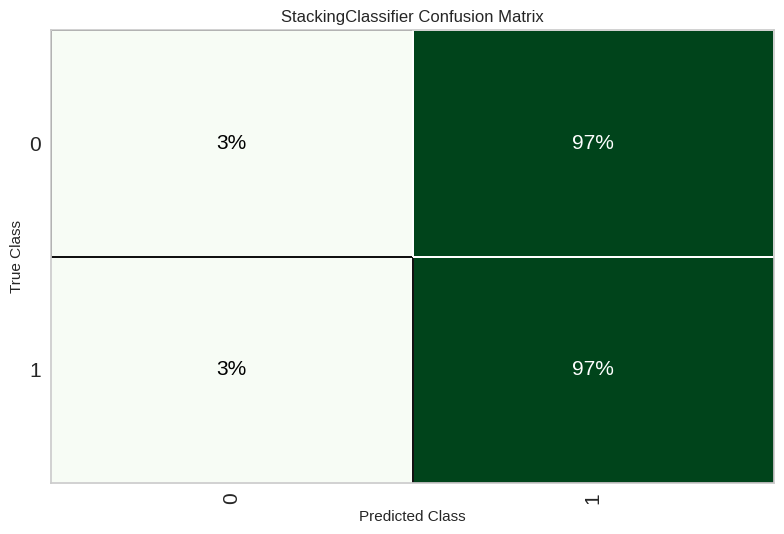

In [21]:
plot_model(model_comp, plot = 'confusion_matrix', plot_kwargs={'percent':True})

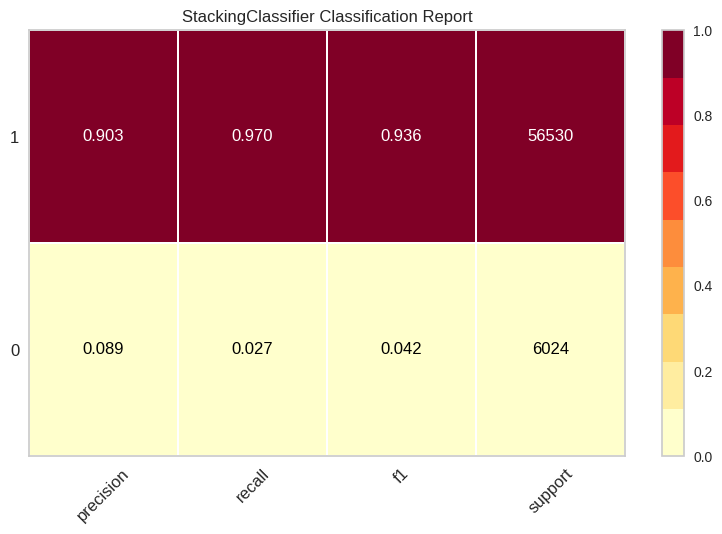

In [22]:
plot_model(model_comp, plot = 'class_report')

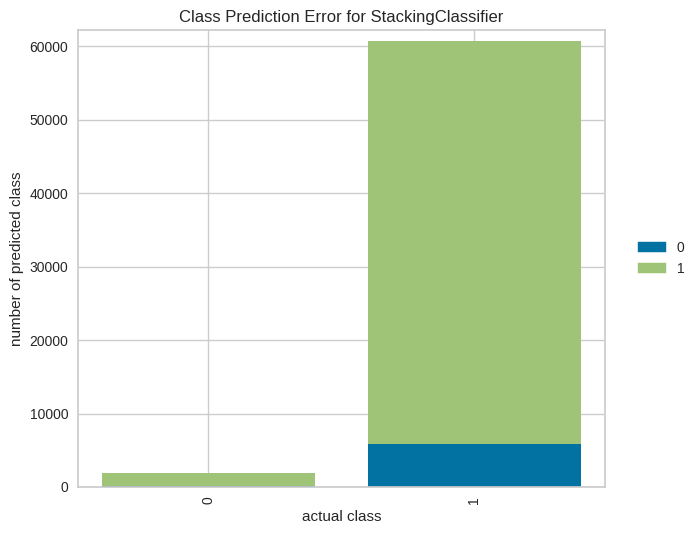

In [23]:
plot_model(model_comp, plot = 'error')

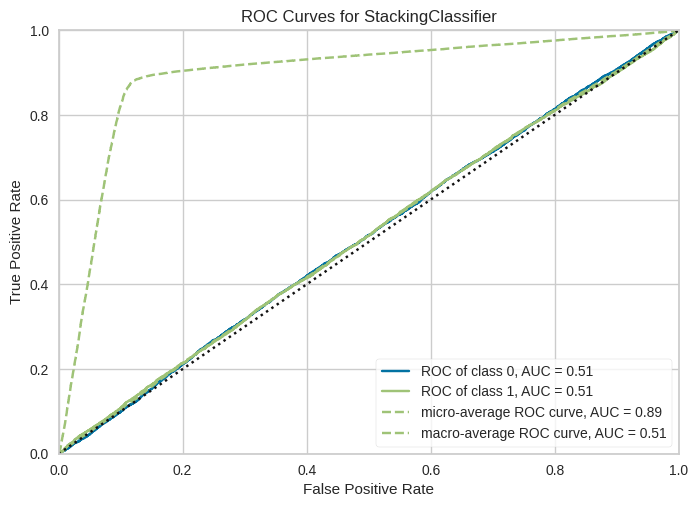

In [24]:
plot_model(model_comp, plot = 'auc')

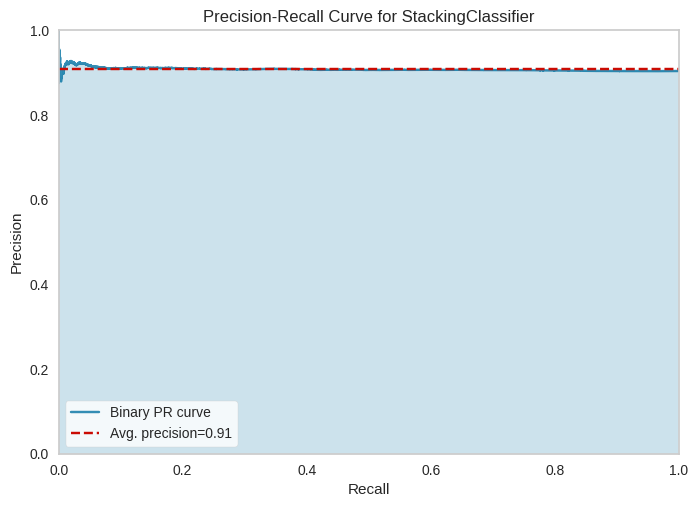

In [25]:
plot_model(model_comp, plot = 'pr')